<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/reservoir/optimizationofoilandgasproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Integration of a process model and simple reservoir model
#@markdown This is a demo of how reservoir simulation can be intergrated into process simulation.
#@markdown <br><br>This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
#%%capture
!pip install neqsim==2.5.35
import neqsim
from neqsim.thermo.thermoTools import *

from neqsim.process import openprocess
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import math
plt.style.use('classic')
%matplotlib inline

     |████████████████████████████████| 55.9 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 62.4 MB/s 


#Setting up a reservoir model


###Setting up the gas reservoir

In [ ]:
from neqsim.process.processTools import simplereservoir,clearProcess,runProcess, getProcess

fluid2 = fluid('srk')
fluid2.addComponent("nitrogen", 0.100)
fluid2.addComponent("CO2", 0.100)
fluid2.addComponent("methane", 90.00)
fluid2.addComponent("ethane", 1.0)
fluid2.addComponent("propane", 1.0)
fluid2.addComponent("i-butane", 1.0)
fluid2.addComponent("n-butane", 0.0)
fluid2.addComponent("n-hexane", 0.1)
fluid2.addComponent("n-heptane", 0.1)
fluid2.addComponent("n-nonane", 0.1)
fluid2.addComponent("nC10", 0.1)
fluid2.addComponent("nC12", 0.1)
fluid2.addComponent("nC15", 0.1)
fluid2.addComponent("nC20", 0.1)
fluid2.addComponent("water", 11.0)
fluid2.setMixingRule(2)
fluid2.setMultiPhaseCheck(True)

fluid2.setPressure(100.0, 'bara')
fluid2.setTemperature(100.0, 'C')

TPflash(fluid2)

clearProcess()
reservoirOps = simplereservoir(fluid2, "gas reservoir", gasvolume=5.0 * 1e9, oilvolume=552.0 * 1e5, watervolume=10.0e6)

producedGasStream = reservoirOps.addGasProducer("SLP_A32562G")
producedGasStream.setFlowRate(3.63, "MSm3/day")

runProcess()
getProcess().save('gasreservoir.neqsim')

###Oil reservoir

In [ ]:
from neqsim.process.processTools import simplereservoir,clearProcess,runProcess, getProcess

fluid1 = fluid('srk')
fluid1.addComponent("nitrogen", 0.100)
fluid1.addComponent("CO2", 0.100)
fluid1.addComponent("methane", 30.00)
fluid1.addComponent("ethane", 1.0)
fluid1.addComponent("propane", 1.0)
fluid1.addComponent("i-butane", 1.0)
fluid1.addComponent("n-butane", 0.0)
fluid1.addComponent("n-hexane", 0.1)
fluid1.addComponent("n-heptane", 0.1)
fluid1.addComponent("n-nonane", 1.0)
fluid1.addComponent("nC10", 3.0)
fluid1.addComponent("nC12", 3.0)
fluid1.addComponent("nC15", 3.0)
fluid1.addComponent("nC20", 3.0)
fluid1.addComponent("water", 11.0)
fluid1.setMixingRule(2)
fluid1.setMultiPhaseCheck(True)

fluid1.setPressure(100.0, 'bara')
fluid1.setTemperature(100.0, 'C')

TPflash(fluid1)

clearProcess()
reservoirOps = simplereservoir(fluid1, "oil reservoir", gasvolume=5.0 * 1e7, oilvolume=552.0 * 1e6, watervolume=10.0e6)

injectionWaterStream = reservoirOps.addWaterInjector("SLP_A32562W")
injectionWaterStream.setFlowRate(10000000.1, "kg/day")

producedOilStream = reservoirOps.addOilProducer("SLP_A32562O")
producedOilStream.setFlowRate(900000.63*24.0, "kg/day")
runProcess()
getProcess().save('oilreservoir.neqsim')

# Establish the oil and gas process
A simple oil and gas process is established

In [ ]:
from neqsim.process.processTools import valve,stream,simplereservoir,clearProcess,runProcess, getProcess,separator3phase,heater,separator,compressor,setpoint,recycle,mixer,pump

gasreservoir = openprocess('gasreservoir.neqsim')
oilreservoir = openprocess('oilreservoir.neqsim')

clearProcess()

wellStreamGas = stream(gasreservoir.getUnit('gas reservoir').getGasProducer(0).getStream())
wellStreamGas.setName("well stream gas")
wellStreamGas.setTemperature(40.0, "C")
wellStreamGas.setPressure(120.0, "bara")

wellStreamOil = stream(oilreservoir.getUnit('oil reservoir').getOilProducer(0).getStream())
wellStreamOil.setName("well stream oil")
wellStreamOil.setTemperature(60.0, "C")
wellStreamOil.setPressure(15.0, "bara")

wellheater = heater(wellStreamGas)
wellheater.setName("well stream cooler/heater")
wellheater.setOutPressure(62.21)
wellheater.setOutTemperature(273.15+35.21);

wellvalve = valve(wellheater.getOutStream())
wellvalve.setName("inlet choke valve")
wellvalve.setOutletPressure(52.21);

inletSeparator = separator3phase(wellvalve.getOutStream())
inletSeparator.setName("1st stage separator")

oilToInletSep = stream(fluid1.clone())
oilToInletSep.setFlowRate(1e-10, "kg/hr")
inletSeparator.addStream(oilToInletSep)

valve2 = valve(inletSeparator.getOilOutStream())
valve2.setName("oil HP to MP valve");
valve2.setOutletPressure(15.0);

cooler1 = heater(valve2.getOutStream())
cooler1.setName("oil cooler/heater to 2nd stage")
cooler1.setOutTemperature(323.15)

waterDPvalve =  valve(inletSeparator.getWaterOutStream())
waterDPvalve.setName("Water HP to LP valve")
waterDPvalve.setOutletPressure(1.01325)

waterStabSep = separator(waterDPvalve.getOutStream())
waterStabSep.setName('water degasing separator"')

waterToTreatment = stream(waterStabSep.getLiquidOutStream())
waterToTreatment.setName("water to treatment")
		
mpseparator = separator3phase(cooler1.getOutStream())
mpseparator.setName("2nd stage separator")
mpseparator.addStream(wellStreamOil)

oilToSep = stream(fluid1.clone())
oilToSep.setFlowRate(1e-10, "kg/hr")
mpseparator.addStream(oilToSep)

valvempValve = valve(mpseparator.getOilOutStream())
valvempValve.setName("oil MP to LP valve")
valvempValve.setOutletPressure(2.8)

lpseparator = separator3phase(valvempValve.getOutStream())
lpseparator.setName("3rd stage separator")

stableOilStream  = stream(lpseparator.getOilOutStream())
stableOilStream.setName("stable oil")
		
lpcompressor = compressor(lpseparator.getGasOutStream())
lpcompressor.setName("1st stage recompressor");
compressorPresSet2 =  setpoint("comp pres LP set", lpcompressor, "pressure",valve2.getOutStream());

lpgasheater = heater(lpcompressor.getOutStream())
lpgasheater.setName('1st stage gas heat exchanger')
lpgasheater.setOutTemperature(298.15)

lpscrubber = separator(lpgasheater.getOutStream())
lpscrubber.setName("2nd stage scrubber")
liqFromlpscrubber = lpscrubber.getLiquidOutStream()

lpscrubberResyc = recycle(liqFromlpscrubber)
lpscrubberResyc.setName("mpscrubberRes")
lpscrubberResyc.setOutletStream(oilToSep)

mixermp = mixer("mp gas mixer")
mixermp.addStream(lpscrubber.getGasOutStream())
mixermp.addStream(mpseparator.getGasOutStream())

compressor2stage = compressor(mixermp.getOutStream())
compressor2stage.setName("2nd stage recompressor")

compressorPresSet = setpoint("comp pres set", compressor2stage, "pressure",inletSeparator)
		
secondndstagecooler = heater(compressor2stage.getOutStream())
secondndstagecooler.setName("2nd stage cooler")
secondndstagecooler.setOutTemperature(298.0)

scrubbberfrom2ndstage = separator(secondndstagecooler.getOutStream())
scrubbberfrom2ndstage.setName("scrubber of mix gas HP")

mixer = mixer("HP rich gas mixer")
mixer.addStream(inletSeparator.getGasOutStream())
mixer.addStream(scrubbberfrom2ndstage.getGasOutStream())

dewPointScrubberCooler = heater(mixer.getOutStream())
dewPointScrubberCooler.setName("dew point scrubber cooler2")
dewPointScrubberCooler.setOutTemperature(273.15+32.3)

mpscrubber = separator(dewPointScrubberCooler.getOutStream())
mpscrubber.setName("dew point control scrubber")

liqFrommpscrubber = mpscrubber.getLiquidOutStream()

mpscrubberResyc = recycle(liqFrommpscrubber)
mpscrubberResyc.setName("hpscrubberRes")
mpscrubberResyc.addStream(scrubbberfrom2ndstage.getLiquidOutStream())
mpscrubberResyc.setOutletStream(oilToInletSep)

exportCompressor1 = compressor(mpscrubber.getGasOutStream())
exportCompressor1.setName("export compressor 1")
exportCompressor1.setOutletPressure(85.0)

exportCooler1 = heater(exportCompressor1.getOutStream())
exportCooler1.setName('export cooler')
exportCooler1.setOutTemperature(30.0, 'C')

exportCompressor2 = compressor(exportCooler1.getOutStream())
exportCompressor2.setName("export compressor 2")
exportCompressor2.setOutletPressure(150.0)

exportCooler2 = heater(exportCompressor2.getOutStream())
exportCooler2.setName('export cooler')
exportCooler2.setOutTemperature(30.0, 'C')

richGas = stream(exportCooler2.getOutStream())
richGas.setName("rich gas")

#waterinjectionComposition = [0]*15
#waterinjectionComposition[14]= 1.0
#waterfluid = fluid1.clone()
#waterfluid.setMolarComposition(waterinjectionComposition)

#waterInjectionStream = stream(waterfluid)
waterInjectionStream = injectionWaterStream.clone()
waterInjectionStream.setName('injectionwater')
waterInjectionStream.setPressure(1.0, 'bara')
waterInjectionStream.setTemperature(10.0, 'C')
waterpump = pump(waterInjectionStream, 5.0)
waterpump.setOutletPressure(5.0)
waterpump.setName('injection water pump')
waterForInjectionStream = stream(waterpump.getOutStream())
waterForInjectionStream.setName('injected water')

getProcess().getUnit("well stream gas").setStream(wellStreamGas)
getProcess().getUnit("well stream oil").setStream(wellStreamOil)
getProcess().getUnit("well stream cooler/heater").setOutTemperature(66.0, "C")
getProcess().getUnit("well stream cooler/heater").setOutPressure(52.21, "bara")
getProcess().getUnit("inlet choke valve").setOutletPressure(51.21, "bara")
getProcess().getUnit("oil HP to MP valve").setOutletPressure(15.0, "bara")
getProcess().getUnit("oil cooler/heater to 2nd stage").setOutTemperature(85.0, "C")
getProcess().getUnit("oil MP to LP valve").setOutletPressure(1.8, "bara")
getProcess().getUnit("Water HP to LP valve").setOutletPressure(1.01325, "bara")
getProcess().getUnit("dew point scrubber cooler2").setOutTemperature(33.0, "C")
getProcess().getUnit("2nd stage cooler").setOutTemperature(33.0, "C")
getProcess().getUnit("1st stage gas heat exchanger").setOutTemperature(33.0, "C")
getProcess().getUnit("1st stage recompressor").setIsentropicEfficiency(0.75)
getProcess().getUnit("2nd stage recompressor").setIsentropicEfficiency(0.75)
getProcess().getUnit("export compressor 1").setIsentropicEfficiency(0.75)
getProcess().getUnit("export compressor 2").setIsentropicEfficiency(0.75)
getProcess().run()

getProcess().save('gasprocess.neqsim')

#Read results from simulation

In [ ]:
#Read results of last year
GasOilProcess = openprocess('gasprocess.neqsim')
GasLiqidRatio = GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
compressorPower1 = GasOilProcess.getUnit("1st stage recompressor").getPower()/1.0e3
compressorPower2 = GasOilProcess.getUnit("2nd stage recompressor").getPower()/1.0e3
injectionWaterPumpPower = GasOilProcess.getUnit("injection water pump").getPower()/1.0e3
exportCompressorPower = GasOilProcess.getUnit("export compressor 1").getPower()/1.0e3
exportCompressorPower2 = GasOilProcess.getUnit("export compressor 2").getPower()/1.0e3
cooler1Duty = GasOilProcess.getUnit("1st stage gas heat exchanger").getDuty()/1e3
cooler2Duty = GasOilProcess.getUnit("2nd stage cooler").getDuty()/1e3

wellStreamFLowMSm3day = GasOilProcess.getUnit("well stream gas").getFluid().getFlowRate("MSm3/day")
wellStreamOilFLowMSm3day = GasOilProcess.getUnit("well stream oil").getFluid().getFlowRate("MSm3/day")
richGasFLowMSm3day = GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("MSm3/day")
richGasExportPressure = GasOilProcess.getUnit("rich gas").getPressure("bara")
gasInletSepFlowMSm3day = GasOilProcess.getUnit("1st stage separator").getGasOutStream().getFluid().getFlowRate("MSm3/day")
stableOilFLowm3hr = GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
waterToTreatmentRatem3hr = GasOilProcess.getUnit("water to treatment").getFluid().getFlowRate("m3/hr")
resycleFLowDewPointScrubber = GasOilProcess.getUnit("dew point control scrubber").getLiquidOutStream().getFluid().getFlowRate("kg/hr")
GOR=GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/ GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
TVPofexportoil = GasOilProcess.getUnit("stable oil").TVP(30.0, "C")
CCB_exportgas = GasOilProcess.getUnit("rich gas").CCB("bara")
CCT_exportgas = GasOilProcess.getUnit("rich gas").CCT("C")

print("rich gas flow", richGasFLowMSm3day, " MSm3/day")
print("1st stage recompressor power", compressorPower1, " kW")
print("2nd stage recompressor power", compressorPower2, " kW")
print("export compressor power 1 ", exportCompressorPower, " kW")
print("export compressor power 2 ", exportCompressorPower2, " kW")
print("injection water pump power", injectionWaterPumpPower, " kW")
print("1st stage gas cooler duty ", cooler1Duty, " kW")
print("2nd stage cooler duty ", cooler2Duty, " kW")
print("stable oil production ", stableOilFLowm3hr, " m3/hr")
print("rich gas production ", richGasFLowMSm3day, " MS3/day")
print("GOR ", GOR)
print("gas export pressure ", richGasExportPressure)
print("TVP of export oil ", TVPofexportoil)
print("cricondenbar pressure of rich gas ", CCB_exportgas, " bara")
print("cricondentherm temperature of rich gas ", CCT_exportgas, " C")

rich gas flow 5.167601884861893  MSm3/day
1st stage recompressor power 1240.382911567433  kW
2nd stage recompressor power 3842.524454842531  kW
export compressor power 1  4206.242133161944  kW
export compressor power 2  4504.784302350579  kW
injection water pump power 58.49221952980757  kW
1st stage gas cooler duty  -1970.1201364588333  kW
2nd stage cooler duty  -5628.653130562239  kW
stable oil production  1099.9709631749863  m3/hr
rich gas production  5.167601884861893  MS3/day
GOR  195.7476628120098
gas export pressure  150.0
TVP of export oil  1.331913269783406
cricondenbar pressure of rich gas  107.8260712186288  bara
cricondentherm temperature of rich gas  34.83291461440007  C


# Running the combined reservoir and process model for the lifetime of the field
In this case we do not evaluate the capacity limitation of the pumps and compressors. Importing reservoir simulation ad process simulation and running simlation



sim year  0.0
sim year  1.0
sim year  2.0
sim year  3.0
sim year  4.0


Text(0, 0.5, 'Rich Gas FLow [MSm3/day]')

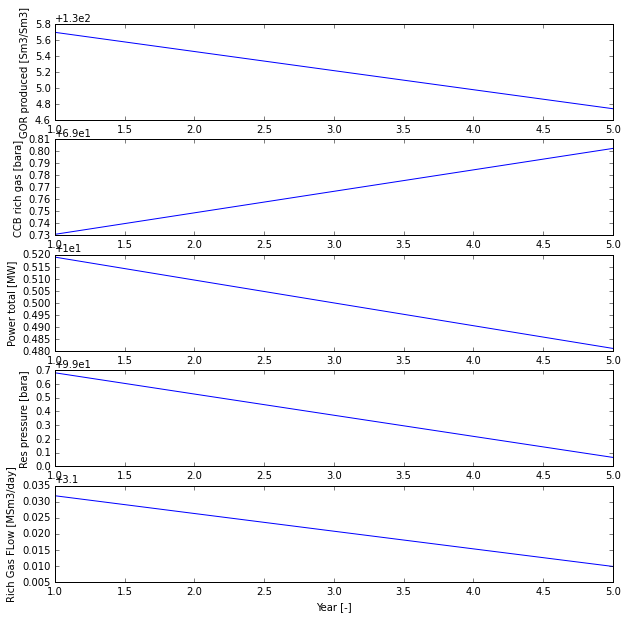

In [ ]:
from neqsim.process import getProcess, openprocess
import matplotlib.pyplot as plt
gasresmodel = openprocess('gasreservoir.neqsim')
oilresmodel = openprocess('oilreservoir.neqsim')
GasOilProcess = openprocess('gasprocess.neqsim')

gasreservoir = gasresmodel.getUnit('gas reservoir')
gaswellStream = gasreservoir.getGasProducer(0).getStream()

oilreservoir = oilresmodel.getUnit('oil reservoir')
oilwellStream = oilreservoir.getOilProducer(0).getStream()

initGasResPressure = gasreservoir.getReservoirFluid().getPressure('bara')
initOilPressure = oilreservoir.getReservoirFluid().getPressure('bara')
initGasFLowRate = gaswellStream.getFlowRate('kg/hr')*24.0
initOilFLowRate = oilwellStream.getFlowRate('kg/hr')*24.0
deltat = 24*60*60.0*365
gasresmodel.setTimeStep(deltat)

time = []
pressure = []
pressureout = []
GORprocess = []
cricondenbarrichgas = []
power = []
richGasFLowMSm3day = []

for step in range(5):
    print('sim year ' , gasreservoir.getTime()/(60.0*60*24*365))
    gasresmodel.runTransient()
    gaswellStream.setFlowRate(initGasFLowRate*(gasreservoir.getReservoirFluid().getPressure('bara')- GasOilProcess.getUnit("inlet choke valve").getOutStream().getPressure('bara'))/initGasResPressure, "kg/day")
    oilwellStream.setFlowRate(initOilFLowRate*(oilreservoir.getReservoirFluid().getPressure('bara')- GasOilProcess.getUnit("oil HP to MP valve").getOutStream().getPressure('bara'))/initOilPressure, "kg/day")
    GasOilProcess.getUnit("well stream gas").setStream(gaswellStream)
    GasOilProcess.getUnit("well stream oil").setStream(oilwellStream)
    GasOilProcess.run()
    time.append(gasreservoir.getTime()/(60.0*60*24*365))
    inlet_pressure = GasOilProcess.getUnit("inlet choke valve").getOutStream().getPressure('bara')
    GOR=GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
    GORprocess.append(GOR)
    cricondenbarrichgas.append(GasOilProcess.getUnit("rich gas").CCB("bara"))
    power.append(GasOilProcess.getPower("W")/1.0e6)
    pressure.append(gasreservoir.getReservoirFluid().getPressure('bara'))
    richGasFLowMSm3day.append(GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("MSm3/day"))
    pressureout.append(GasOilProcess.getUnit("rich gas").getPressure('bara'))


plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
plt.subplot(5, 1, 1)
plt.plot(time, GORprocess)
plt.xlabel('Year [-]')
plt.ylabel('GOR produced [Sm3/Sm3]')
plt.subplot(5, 1, 2)
plt.plot(time, cricondenbarrichgas)
plt.xlabel('Year [-]')
plt.ylabel('CCB rich gas [bara]')
plt.subplot(5, 1, 3)
plt.plot(time, power)
plt.xlabel('Year [-]')
plt.ylabel('Power total [MW]')
plt.subplot(5, 1, 4)
plt.plot(time, pressure)
plt.xlabel('Year [-]')
plt.ylabel('Res pressure [bara]')
plt.subplot(5, 1, 5)
plt.plot(time, richGasFLowMSm3day)
plt.xlabel('Year [-]')
plt.ylabel('Rich Gas FLow [MSm3/day]')


# Calculations using a model using compressor and pump charts
.....

We start by establising pump and compressor charts including surge conditions.

In [ ]:
from neqsim.process import compressorChart,compressorSurgeCurve, compressorStoneWallCurve

MW=28.01
inlepPres=100.0
inletTemp=26.2
Zinlet=0.89
curveConditions = [MW, inlepPres, inletTemp, Zinlet]

flowFactor = 0.7

speed = [12913, 12298, 11683, 11098, 10453, 9224, 8609, 8200]
flow =[
                [2789.1285, 3174.0375, 3689.2288, 4179.4503, 4570.2768, 4954.7728, 5246.0329,
                        5661.0331],
                [2571.1753, 2943.7254, 3440.2675, 3837.4448, 4253.0898, 4668.6643, 4997.1926,
                        5387.4952],
                [2415.3793, 2763.0706, 3141.7095, 3594.7436, 4047.6467, 4494.1889, 4853.7353,
                        5138.7858],
                [2247.2043, 2799.7342, 3178.3428, 3656.1551, 4102.778, 4394.1591, 4648.3224,
                        4840.4998],
                [2072.8397, 2463.9483, 2836.4078, 3202.5266, 3599.6333, 3978.0203, 4257.0022,
                        4517.345],
                [1835.9552, 2208.455, 2618.1322, 2940.8034, 3244.7852, 3530.1279, 3753.3738,
                        3895.9746],
                [1711.3386, 1965.8848, 2356.9431, 2685.9247, 3008.5154, 3337.2855, 3591.5092],
                [1636.5807, 2002.8708, 2338.0319, 2642.1245, 2896.4894, 3113.6264, 3274.8764,
                        3411.2977]]
flow = [[j*flowFactor for j in i] for i in flow]
head = [
                [80.0375, 78.8934, 76.2142, 71.8678, 67.0062, 60.6061, 53.0499, 39.728],
                [72.2122, 71.8369, 68.9009, 65.8341, 60.7167, 54.702, 47.2749, 35.7471],
                [65.1576, 64.5253, 62.6118, 59.1619, 54.0455, 47.0059, 39.195, 31.6387],
                [58.6154, 56.9627, 54.6647, 50.4462, 44.4322, 38.4144, 32.9084, 28.8109],
                [52.3295, 51.0573, 49.5283, 46.3326, 42.3685, 37.2502, 31.4884, 25.598],
                [40.6578, 39.6416, 37.6008, 34.6603, 30.9503, 27.1116, 23.2713, 20.4546],
                [35.2705, 34.6359, 32.7228, 31.0645, 27.0985, 22.7482, 18.0113],
                [32.192, 31.1756, 29.1329, 26.833, 23.8909, 21.3324, 18.7726, 16.3403]
        ]

polyEff =  [
                [77.2452238409573, 79.4154186459363, 80.737960012489, 80.5229826589649,
                        79.2210931638144, 75.4719133864634, 69.6034181197298, 58.7322388482707],
                [77.0107837113504, 79.3069974136389, 80.8941189021135, 80.7190194665918,
                        79.5313242980328, 75.5912622896367, 69.6846136362097, 60.0043057990909],
                [77.0043065299874, 79.1690958847856, 80.8038169975675, 80.6543975614197,
                        78.8532389102705, 73.6664774270613, 66.2735600426727, 57.671664571658],
                [77.0716623789093, 80.4629750233093, 81.1390811169072, 79.6374242667478,
                        75.380928428817, 69.5332969549779, 63.7997587622339, 58.8120614497758],
                [76.9705872525642, 79.8335492585324, 80.9468133671171, 80.5806471927835,
                        78.0462158225426, 73.0403707523258, 66.5572286338589, 59.8624822515064],
                [77.5063036680357, 80.2056198362559, 81.0339108025933, 79.6085962687939,
                        76.3814534404405, 70.8027503005902, 64.6437367160571, 60.5299349982342],
                [77.8175271586685, 80.065165942218, 81.0631362122632, 79.8955051771299,
                        76.1983240929369, 69.289982774309, 60.8567149372229],
                [78.0924334304045, 80.9353551568667, 80.7904437766234, 78.8639325223295,
                        75.2170936751143, 70.3105081673411, 65.5507568533569, 61.0391468300337]
                 ]

compressorChart(exportCompressor1, curveConditions, speed, flow, head, polyEff)
exportCompressor1.getCompressorChart().setHeadUnit('meter')
exportCompressor1.getCompressorChart().setHeadUnit("kJ/kg")

surgeFlow = [2789.1285, 2571.1753, 2415.3793, 2247.2043, 2072.8397, 1835.9552, 1711.3386, 1636.5807]
surgeFlow = [j*flowFactor for j in surgeFlow]
surgeHead = [80.0375, 72.2122, 65.1576, 58.6154,52.3295,40.6578,35.2705,32.192 ]
compressorSurgeCurve(exportCompressor1, curveConditions, surgeFlow, surgeHead)

exportCompressor1.setUsePolytropicCalc(True)
exportCompressor1.getAntiSurge().setActive(True)
exportCompressor1.getAntiSurge().setSurgeControlFactor(1.05)

exportCompressor1.setSpeed(11000)
exportCompressor1.run()
inletCompFLuid = exportCompressor1.getInStream().getFluid()
extiCompFLuid = exportCompressor1.getOutStream().getFluid()
fluidHead = exportCompressor1.getPolytropicHead()
surgeFLow = exportCompressor1.getCompressorChart().getSurgeCurve().getSurgeFlow(fluidHead)
power = exportCompressor1.getPower()
fluidEff = exportCompressor1.getPolytropicEfficiency()
print('feed flow ', inletCompFLuid.getFlowRate('m3/hr'), ' surgeflow ', surgeFLow,' inletpres ', inletCompFLuid.getPressure('bara'), ' outpres ', extiCompFLuid.getPressure('bara'), ' fluidhead ', fluidHead, ' meter ',  ' fluideff ', fluidEff, ' power ', power/1e6, ' MW')
printFrame(extiCompFLuid)

feed flow  4087.7016827230505  surgeflow  3361.33748973602  inletpres  51.21  outpres  73.70307375491848  fluidhead  48.68654201491223  meter   fluideff  0.7591436879079876  power  2.9202885812900106  MW
                           total                gas                       
           nitrogen   1.29376E-3         1.29376E-3        [mole fraction]
                CO2   2.07719E-3         2.07719E-3        [mole fraction]
            methane    9.3096E-1          9.3096E-1        [mole fraction]
             ethane   2.18039E-2         2.18039E-2        [mole fraction]
            propane   2.20669E-2         2.20669E-2        [mole fraction]
           i-butane   1.89421E-2         1.89421E-2        [mole fraction]
           n-butane          0E0                0E0        [mole fraction]
           n-hexane   8.59685E-4         8.59685E-4        [mole fraction]
          n-heptane   6.50809E-4         6.50809E-4        [mole fraction]
           n-nonane   2.95992E-4         2.959

In [ ]:
from neqsim.process import compressorChart,compressorSurgeCurve, compressorStoneWallCurve

MW=28.01
inlepPres=100.0
inletTemp=26.2
Zinlet=0.89
curveConditions = [MW, inlepPres, inletTemp, Zinlet]

flowFactor = 0.7

speed = [12913, 12298, 11683, 11098, 10453, 9224, 8609, 8200]
flow =[
                [2789.1285, 3174.0375, 3689.2288, 4179.4503, 4570.2768, 4954.7728, 5246.0329,
                        5661.0331],
                [2571.1753, 2943.7254, 3440.2675, 3837.4448, 4253.0898, 4668.6643, 4997.1926,
                        5387.4952],
                [2415.3793, 2763.0706, 3141.7095, 3594.7436, 4047.6467, 4494.1889, 4853.7353,
                        5138.7858],
                [2247.2043, 2799.7342, 3178.3428, 3656.1551, 4102.778, 4394.1591, 4648.3224,
                        4840.4998],
                [2072.8397, 2463.9483, 2836.4078, 3202.5266, 3599.6333, 3978.0203, 4257.0022,
                        4517.345],
                [1835.9552, 2208.455, 2618.1322, 2940.8034, 3244.7852, 3530.1279, 3753.3738,
                        3895.9746],
                [1711.3386, 1965.8848, 2356.9431, 2685.9247, 3008.5154, 3337.2855, 3591.5092],
                [1636.5807, 2002.8708, 2338.0319, 2642.1245, 2896.4894, 3113.6264, 3274.8764,
                        3411.2977]]

flow = [[j*flowFactor for j in i] for i in flow]
head = [
                [80.0375, 78.8934, 76.2142, 71.8678, 67.0062, 60.6061, 53.0499, 39.728],
                [72.2122, 71.8369, 68.9009, 65.8341, 60.7167, 54.702, 47.2749, 35.7471],
                [65.1576, 64.5253, 62.6118, 59.1619, 54.0455, 47.0059, 39.195, 31.6387],
                [58.6154, 56.9627, 54.6647, 50.4462, 44.4322, 38.4144, 32.9084, 28.8109],
                [52.3295, 51.0573, 49.5283, 46.3326, 42.3685, 37.2502, 31.4884, 25.598],
                [40.6578, 39.6416, 37.6008, 34.6603, 30.9503, 27.1116, 23.2713, 20.4546],
                [35.2705, 34.6359, 32.7228, 31.0645, 27.0985, 22.7482, 18.0113],
                [32.192, 31.1756, 29.1329, 26.833, 23.8909, 21.3324, 18.7726, 16.3403]
        ]

polyEff =  [
                [77.2452238409573, 79.4154186459363, 80.737960012489, 80.5229826589649,
                        79.2210931638144, 75.4719133864634, 69.6034181197298, 58.7322388482707],
                [77.0107837113504, 79.3069974136389, 80.8941189021135, 80.7190194665918,
                        79.5313242980328, 75.5912622896367, 69.6846136362097, 60.0043057990909],
                [77.0043065299874, 79.1690958847856, 80.8038169975675, 80.6543975614197,
                        78.8532389102705, 73.6664774270613, 66.2735600426727, 57.671664571658],
                [77.0716623789093, 80.4629750233093, 81.1390811169072, 79.6374242667478,
                        75.380928428817, 69.5332969549779, 63.7997587622339, 58.8120614497758],
                [76.9705872525642, 79.8335492585324, 80.9468133671171, 80.5806471927835,
                        78.0462158225426, 73.0403707523258, 66.5572286338589, 59.8624822515064],
                [77.5063036680357, 80.2056198362559, 81.0339108025933, 79.6085962687939,
                        76.3814534404405, 70.8027503005902, 64.6437367160571, 60.5299349982342],
                [77.8175271586685, 80.065165942218, 81.0631362122632, 79.8955051771299,
                        76.1983240929369, 69.289982774309, 60.8567149372229],
                [78.0924334304045, 80.9353551568667, 80.7904437766234, 78.8639325223295,
                        75.2170936751143, 70.3105081673411, 65.5507568533569, 61.0391468300337]
                 ]

compressorChart(exportCompressor2, curveConditions, speed, flow, head, polyEff)
exportCompressor2.getCompressorChart().setHeadUnit('meter')
exportCompressor2.getCompressorChart().setHeadUnit("kJ/kg")

surgeFlow = [2789.1285, 2571.1753, 2415.3793, 2247.2043, 2072.8397, 1835.9552, 1711.3386, 1636.5807]
surgeFlow = [j*flowFactor for j in surgeFlow]
surgeHead = [80.0375, 72.2122, 65.1576, 58.6154,52.3295,40.6578,35.2705,32.192 ]
compressorSurgeCurve(exportCompressor2, curveConditions, surgeFlow, surgeHead)

exportCompressor2.setUsePolytropicCalc(True)
exportCompressor2.getAntiSurge().setActive(True)
exportCompressor2.getAntiSurge().setSurgeControlFactor(1.05)

exportCompressor2.setSpeed(11500)
exportCompressor2.run()
inletCompFLuid = exportCompressor2.getInStream().getFluid()
extiCompFLuid = exportCompressor2.getOutStream().getFluid()
fluidHead = exportCompressor2.getPolytropicHead()
surgeFLow = exportCompressor2.getCompressorChart().getSurgeCurve().getSurgeFlow(fluidHead)
power = exportCompressor2.getPower()
fluidEff = exportCompressor2.getPolytropicEfficiency()
print('feed flow ', inletCompFLuid.getFlowRate('m3/hr'), ' surgeflow ', surgeFLow,' inletpres ', inletCompFLuid.getPressure('bara'), ' outpres ', extiCompFLuid.getPressure('bara'), ' fluidhead ', fluidHead, ' meter ',  ' fluideff ', fluidEff, ' power ', power/1e6, ' MW')
printFrame(extiCompFLuid)

feed flow  2284.214837996858  surgeflow  1579.197689546516  inletpres  85.0  outpres  136.7042458753962  fluidhead  59.21698877586482  meter   fluideff  0.8156754694294812  power  3.3057479998710173  MW
                           total                gas                       
           nitrogen   1.29376E-3         1.29376E-3        [mole fraction]
                CO2   2.07719E-3         2.07719E-3        [mole fraction]
            methane    9.3096E-1          9.3096E-1        [mole fraction]
             ethane   2.18039E-2         2.18039E-2        [mole fraction]
            propane   2.20669E-2         2.20669E-2        [mole fraction]
           i-butane   1.89421E-2         1.89421E-2        [mole fraction]
           n-butane          0E0                0E0        [mole fraction]
           n-hexane   8.59685E-4         8.59685E-4        [mole fraction]
          n-heptane   6.50809E-4         6.50809E-4        [mole fraction]
           n-nonane   2.95992E-4         2.9599

# Running life time calculations for a field
In this case we will use compressor and pump characteristics to and evaluate the process performance during the life time of the field.

In [ ]:
runProcess()

In [ ]:
getProcess().save('gasprocess.neqsim')

In [ ]:
from scipy.optimize import fsolve
from scipy import optimize
from scipy.optimize import Bounds

GasOilProcess = openprocess('gasprocess.neqsim')
GasOilProcess.getUnit('well stream gas').setFlowRate(0.5*initGasFLowRate*(gasreservoir.getReservoirFluid().getPressure('bara')- GasOilProcess.getUnit("inlet choke valve").getOutStream().getPressure('bara'))/initGasResPressure, "kg/day")
pressureSet = 150.0
maxSpeed = 13000
minSpeed = 10000

def calOutPres(speed):
  GasOilProcess.getUnit('export compressor 1').setSpeed(int(speed))
  GasOilProcess.getUnit('export compressor 2').setSpeed(int(speed))
  GasOilProcess.run()
  print('speed ', int(speed), ' pressure ', GasOilProcess.getUnit('rich gas').getPressure('bara'))
  return GasOilProcess.getUnit('rich gas').getPressure('bara')-pressureSet

speed = optimize.bisect(calOutPres, minSpeed,maxSpeed, xtol=2.1, maxiter=10, disp=False)
print('speed ', speed, ' pressure ', GasOilProcess.getUnit('rich gas').getPressure('bara'))


speed  10000  pressure  106.10608755141365
speed  13000  pressure  173.5538122164415
speed  11500  pressure  133.74036986551388
speed  12250  pressure  151.8062395628677
speed  11875  pressure  142.3744543624078
speed  12062  pressure  147.0278221069684
speed  12156  pressure  149.36224581501867
speed  12203  pressure  150.53327762634922
speed  12179  pressure  149.96379079445134
speed  12191  pressure  150.20987657514954
speed  12185  pressure  150.04840055542465
speed  12182  pressure  150.0424366284465
speed  12179.6875  pressure  150.0424366284465


sim year  0.0
speed  10000  pressure  104.90995759366352
speed  13000  pressure  171.2646092546384
speed  11500  pressure  132.37473292145458
speed  12250  pressure  150.07153644790145
speed  11875  pressure  140.81355454182645
speed  12062  pressure  145.33744560144626
speed  12156  pressure  147.73678345580186
speed  12203  pressure  148.84855530013806
speed  12226  pressure  149.44586556993787
speed  12238  pressure  149.75840642512657
speed  12244  pressure  149.9149089311944
speed  12247  pressure  149.99321828767873
sim year  1.0
speed  10000  pressure  104.94001973791572
speed  13000  pressure  171.33247826484768
speed  11500  pressure  132.403265886751
speed  12250  pressure  150.11194951533673
speed  11875  pressure  140.8508346687794
speed  12062  pressure  145.37975270341346
speed  12156  pressure  147.67663080067112
speed  12203  pressure  148.88957444603273
speed  12226  pressure  149.4865337501821
speed  12238  pressure  149.7989618675484
speed  12244  pressure  149.95533

Text(0, 0.5, 'Rich Gas FLow [MSm3/day]')

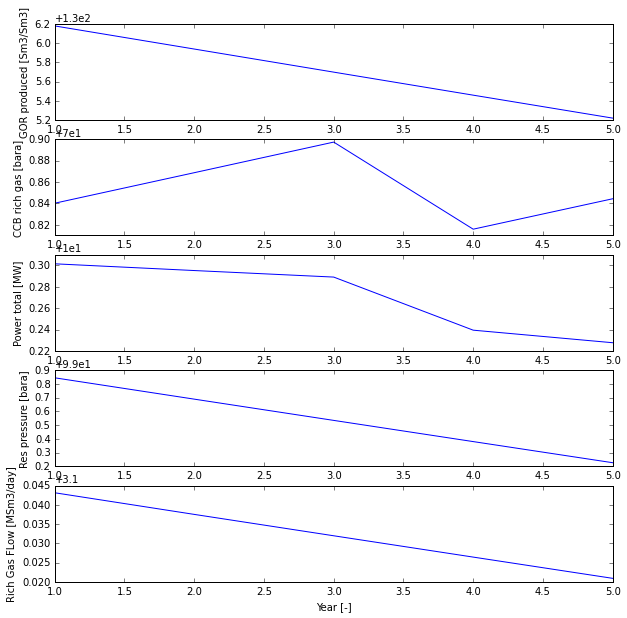

In [ ]:
from neqsim.process import getProcess, openprocess
import matplotlib.pyplot as plt
gasresmodel = openprocess('gasreservoir.neqsim')
oilresmodel = openprocess('oilreservoir.neqsim')
GasOilProcess = openprocess('gasprocess.neqsim')

gasreservoir = gasresmodel.getUnit('gas reservoir')
gaswellStream = gasreservoir.getGasProducer(0).getStream()

oilreservoir = oilresmodel.getUnit('oil reservoir')
oilwellStream = oilreservoir.getOilProducer(0).getStream()

initGasResPressure = gasreservoir.getReservoirFluid().getPressure('bara')
initOilPressure = oilreservoir.getReservoirFluid().getPressure('bara')
initGasFLowRate = gaswellStream.getFlowRate('kg/hr')*24.0
initOilFLowRate = oilwellStream.getFlowRate('kg/hr')*24.0
deltat = 24*60*60.0*365
gasresmodel.setTimeStep(deltat)

time = []
pressure = []
pressureout = []
GORprocess = []
cricondenbarrichgas = []
power = []
richGasFLowMSm3day = []

for step in range(5):
    print('sim year ' , gasreservoir.getTime()/(60.0*60*24*365))
    gaswellStream.setFlowRate(initGasFLowRate*(gasreservoir.getReservoirFluid().getPressure('bara')- GasOilProcess.getUnit("inlet choke valve").getOutStream().getPressure('bara'))/initGasResPressure, "kg/day")
    gaswellStream.run()
    oilwellStream.setFlowRate(initOilFLowRate*(oilreservoir.getReservoirFluid().getPressure('bara')- GasOilProcess.getUnit("oil HP to MP valve").getOutStream().getPressure('bara'))/initOilPressure, "kg/day")
    gasresmodel.runTransient()
    oilresmodel.runTransient()
    GasOilProcess.getUnit("well stream gas").setStream(gaswellStream)
    GasOilProcess.getUnit("well stream oil").setStream(oilwellStream)
    speed = optimize.bisect(calOutPres, minSpeed,maxSpeed, xtol=2.1, maxiter=10, disp=False)
    time.append(gasreservoir.getTime()/(60.0*60*24*365))
    inlet_pressure = GasOilProcess.getUnit("inlet choke valve").getOutStream().getPressure('bara')
    GOR=GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("Sm3/hr")/GasOilProcess.getUnit("stable oil").getFluid().getFlowRate("m3/hr")
    GORprocess.append(GOR)
    cricondenbarrichgas.append(GasOilProcess.getUnit("rich gas").CCB("bara"))
    power.append(GasOilProcess.getPower("W")/1.0e6)
    pressure.append(gasreservoir.getReservoirFluid().getPressure('bara'))
    richGasFLowMSm3day.append(GasOilProcess.getUnit("rich gas").getFluid().getFlowRate("MSm3/day"))
    pressureout.append(GasOilProcess.getUnit("rich gas").getPressure('bara'))


plt.rcParams['figure.figsize'] = [10, 10]
fig, ax = plt.subplots()
plt.subplot(5, 1, 1)
plt.plot(time, GORprocess)
plt.xlabel('Year [-]')
plt.ylabel('GOR produced [Sm3/Sm3]')
plt.subplot(5, 1, 2)
plt.plot(time, cricondenbarrichgas)
plt.xlabel('Year [-]')
plt.ylabel('CCB rich gas [bara]')
plt.subplot(5, 1, 3)
plt.plot(time, power)
plt.xlabel('Year [-]')
plt.ylabel('Power total [MW]')
plt.subplot(5, 1, 4)
plt.plot(time, pressure)
plt.xlabel('Year [-]')
plt.ylabel('Res pressure [bara]')
plt.subplot(5, 1, 5)
plt.plot(time, richGasFLowMSm3day)
plt.xlabel('Year [-]')
plt.ylabel('Rich Gas FLow [MSm3/day]')
